# Messing Around - Experiments and other Shenanigans

## Reproducing the _Spread_ metric introduced by Zhao at al. (2022)

I know they're using the model _SimCSE with RoBERTa-large base_ which is just
available on GitHub and Huggingface Transformers. The most annoying thing right
now is to determine what is meant with the following sentence:

> For some input $z = (x, y) \in D$, let $f(z)$ denote the vector valued
> features of the input x produced by the model.

What are the _vector-valued features_? Currently, I think these represent the
`embeddings` as used in the following code snippet given in the [example
tutorial](https://github.com/princeton-nlp/SimCSE) of the SimCSE BERT model:

In [ ]:
import torch
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenizer

# Import our models. The package will take care of downloading the models automatically
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")
model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")

# Tokenize input texts
texts = [
    "There's a kid on a skateboard.",
    "A child is skateboarding.",
    "A child resides inside the house."
]
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Get the embeddings
with torch.no_grad():
    embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output

# Calculate cosine similarities
# Cosine similarities are in [-1, 1]. Higher means more similar
cosine_sim_0_1 = 1 - cosine(embeddings[0], embeddings[1])
cosine_sim_0_2 = 1 - cosine(embeddings[0], embeddings[2])

print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (texts[0], texts[1], cosine_sim_0_1))
print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (texts[0], texts[2], cosine_sim_0_2))

Cosine similarity between "There's a kid on a skateboard." and "A child is skateboarding." is: 0.933
Cosine similarity between "There's a kid on a skateboard." and "A child resides inside the house." is: 0.367


The `pooler_output` seems to refer to the value of the classification token, `[CLS]`, in
the BERT-type model. I wasn't sure why this output is particularly important
because it resides as the beginning of the sentence, but given that bert is an
_encoder only_ network this makes sense now: while typical _decoder only_
transformers only look back, encoders look back as well as ahead. The final
result of the classification task of the BERT model thus resides in the first
token before the classified sentence, the `[CLS]` token.

If it is the case that these values are used instead of the tokenizer embeddings
as I first thought, that means the method is more specific to this particular
model architecture than I would like. Still, in the [`transformers`
documentation](https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.BaseModelOutputWithPooling.pooler_output)
it seems like this is not only a feature of BERT models, so it should probably
be fine. I do need to try this out with a different model type tho.

After fiddling for a bit, I've concluded the following. While the
`pooler_output` is not unique to BERT models, it does not seem like the value
necessary for the distance in the paper. It is a single vector while they are
talking about multiple features, each of which is a vector. Therefore, we expect
to take some matrix norm (since the output of $f(z)$ would then be a matrix).
Here is my attempt at reconstructing the method they seem to have used in the
paper.

In [ ]:
import torch
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenizer

# Import our models. The package will take care of downloading the models
# automatically. NOTE: don't use seq2seq.. they're really annoying.
tokenizer = AutoTokenizer.from_pretrained("sshleifer/tiny-gpt2")
model = AutoModel.from_pretrained("sshleifer/tiny-gpt2")

# Tokenize input texts
texts = [
    "There's a kid on a skateboard.",
    "A child is skateboarding.",
    "A child resides inside the house."
]
tokenizer.pad_token = " " # NOTE: I don't know whether this is legit
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Get the embeddings
with torch.no_grad():
    embeddings: torch.Tensor = model(**inputs, output_hidden_states=True, return_dict=True).last_hidden_state

# Calculate distance as defined in the paper
distance_0_1 = (embeddings[0] - embeddings[1]).norm()
distance_0_2 = (embeddings[0] - embeddings[2]).norm()

print("Distance between \"%s\" and \"%s\" is: %.3f" % (texts[0], texts[1], distance_0_1))
print("Distance between \"%s\" and \"%s\" is: %.3f" % (texts[0], texts[2], distance_0_2))

Distance between "There's a kid on a skateboard." and "A child is skateboarding." is: 4.552
Distance between "There's a kid on a skateboard." and "A child resides inside the house." is: 3.318


While this is not an equivalent to the method shown before (no cosine
similarity), this seems like a reasonable substitute for it and I don't find it
unreasonable to imageine that the authors would have gone through similar steps.

### Detour: Token Embeddings

One thing I am curious about to see how much the upper method compares to simply
using the embeddings generated by the tokenizer. Let's see!

In [ ]:
import torch
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenizer

# Import our models. The package will take care of downloading the models
# automatically. NOTE: don't use seq2seq.. they're really annoying.
tokenizer = AutoTokenizer.from_pretrained("sshleifer/tiny-gpt2")
model = AutoModel.from_pretrained("sshleifer/tiny-gpt2")

# Tokenize input texts
texts = [
    "There's a kid on a skateboard.",
    "A child is skateboarding.",
    "A child resides inside the house."
]
tokenizer.pad_token = " " # NOTE: I don't know whether this is legit
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").input_ids

# Calculate distance as defined in the paper
distance_0_1 = (inputs[0] - inputs[1]).double().norm()
distance_0_2 = (inputs[0] - inputs[2]).double().norm()

print("Distance between \"%s\" and \"%s\" is: %.3f" % (texts[0], texts[1], distance_0_1))
print("Distance between \"%s\" and \"%s\" is: %.3f" % (texts[0], texts[2], distance_0_2))

Distance between "There's a kid on a skateboard." and "A child is skateboarding." is: 80844.202
Distance between "There's a kid on a skateboard." and "A child resides inside the house." is: 77876.963


Ah yes, no, absolutely not...

### Detour: Padding Matters

One thing I do notice is that, when considering the distance, the padding used
to make a single batch matters quite a bit. I guess this wasn't an issue before,
but the `tiny-gpt` model doesn't have a built-in padding token. I can iterate
over all the different ascii characters and see what their impact is on the distance.

Spread in difference between two sentences: 
  1. "There's a kid on a skateboard."
  2. "A child is skateboarding."


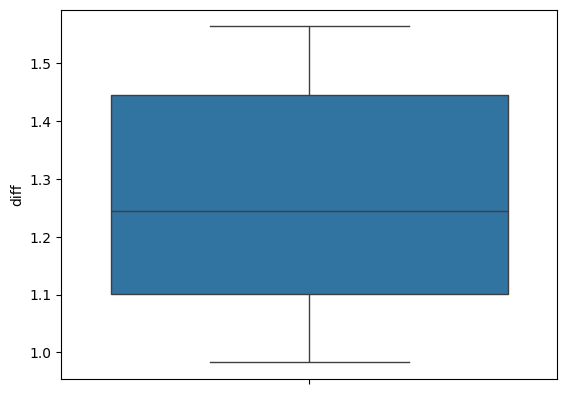

In [ ]:
def get_diff_with_padding(padding=" "):
    tokenizer.pad_token = padding
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        embeddings: torch.Tensor = model(**inputs, output_hidden_states=True, return_dict=True).last_hidden_state

    # Calculate distance as defined in the paper
    distance_0_1 = (embeddings[0] - embeddings[1]).norm().item()
    distance_0_2 = (embeddings[0] - embeddings[2]).norm().item()

    return abs(distance_0_1 - distance_0_2)

import pandas as pd
import seaborn as sns
import string

results = pd.DataFrame({ "char" : list(string.printable) })
results.insert(0, column="diff", value=results["char"].map(get_diff_with_padding))
results = results.sort_values(by="diff")

_ = sns.boxplot(results, y="diff")

print(f"Spread in difference between two sentences: \n  1. \"{texts[0]}\"\n  2. \"{texts[1]}\"")

Given that the average distance of these two sentences are around 1.2, a spread
of .5 does not seem insignificant. Does this matter? Maybe not, but it is
strange. If I would like this to be compatible with various models I should
first figure out how this is generally dealt with.

### Reflection

Now that we effectively have the _Spread_ measure (calculating it fully should
not be a problem as we now have all the puzzle pieces), what is the next step?
We could do a couple of things:

- Compare this measure with that of the **HardenedMetaSet++** technique.
- Show whether this has any value in terms of security
- Continue working on reproducing the paper

While I'm not sure which would be the most effective to work on, I think the
second is the most important to the thesis itself. I'm aware of some stuff in
the current paper that might be reason for concern, but I will let those be for
now. Let's, for now, assume that the current measure is the end-all and be-all
of few-shot dataset hardness.

## Working with GPTFuzzer by Yu et al. (2023)

To that end, I would like to be able to run my own test using the method used in
_GPTFuzzer_. The reason for this tool specifically, is because it generated new
samples from old ones, specifically attacking the adaptability we are trying to
establish. The tool seems really easy to work with and is fully available on
github. It's slightly annoying that it's not available as a package, but this is
my current workaround, maybe I'll submit a PR that makes it easier to interact
with other code.

I switched over to using conda environments because the paper uses this, and I
think it's a good idea given the amount of packages I'll have to deal with.
Furthermore, I'm working in a `devcontainer` which means that not all kernel
features are (readily) available, so too for my NVidia GPU. I've followed [this
stackoverflow
thread](https://stackoverflow.com/questions/72129213/using-gpu-in-vs-code-container)
to fix this.

In [2]:
import sys
import shutil

def in_colab():
    return "google.colab" in sys.modules

def has_conda():
    return shutil.which("conda") is not None

def install_conda():
    !pip install -q condacolab
    import condacolab
    condacolab.install()

if not has_conda():
    if in_colab():
        install_conda()
    else:
        raise RuntimeError("""
            Conda not found, and cannot be automatically installed unless
            in a Google Colab environment.
        """)

!conda install python==3.8 pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
%pip install fschat vllm openai termcolor openpyxl google-generativeai anthropic accelerate chardet pandas ipython

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...
| / - \ | / - \ | / - \ | / - done
Solving environment: | failed with initial frozen solve. Retrying with flexible solve.
WARNING conda.models.version:get_matcher(546): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
WARNING conda.models.version:get_matcher(546): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.9.0.*, but conda is ignoring the .* and treating it as 1.9.0
\ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ |

In [1]:
# kernel might be reset in the previous cell
# thus, the function should be defined again
def in_colab():
    return "google.colab" in sys.modules

if in_colab():
    from google.colab import userdata
else:
    from os import environ

    try:
        with open(".env", "r") as env_file:
            for line in env_file.readlines():
                key, value = line.split("=")
                environ[key] = value
    except FileNotFoundError:
        print("Could not find a .env file...")

def env(key):
    try:
        if in_colab():
            return userdata.get(key)
        return environ[key]
    except KeyError:
        print(
            f"""Could not find variable '{key}'. If you're in a Google Colab
            document, please make sure it's included in the 'secrets',
            otherwise, ensure that it is available as an environment variable
            within the jupyter kernel or added in a .env file in the same place
            as the current jupyter notebook.
        """)

In [ ]:
# This solves gptfuzz needing to be executed in the folder containing the
# `gptfuzzer` folder. Python module resolution is something else...
import sys
if './gptfuzz/' not in sys.path[1]:
    sys.path.insert(1, './gptfuzz/')

try:
    import gptfuzz
    !cd gptfuzz && git pull
except ImportError:
    # means that the gptfuzz folder is not in the current directory
    # so we clone it
    !git clone "https://github.com/cochaviz/GPTFuzz.git" gptfuzz || cd gptfuzz && git pull
    import gptfuzz

import torch

# first, empty cache... I don't have much memory :(
torch.cuda.empty_cache()
torch.cuda.memory._record_memory_history()

from memory_profiler import profile

class FuzzerArgs():
    # the default model is gated, meaning you need permission to access it
    # target_model =  "meta-llama/Llama-2-7b-chat-hf"
    # target_model =  "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    target_model = "ahxt/LiteLlama-460M-1T"
    target_args = {}
    predictor_args = {}
    model_path = "gpt-4"
    seed_path = "gptfuzz/datasets/prompts/GPTFuzzer.csv"
    openai_key = env("OPENAIKEY")
    energy = 1
    max_jailbreak = 10
    max_query = 1000

try:
    gptfuzz.main(FuzzerArgs())
except torch.cuda.OutOfMemoryError:
    print("Process crashed due to lack of memory resources...")
    torch.cuda.memory._dump_snapshot("gpu_usage.pickle")
finally:
    torch.cuda.empty_cache()

Already up to date.


/usr/local/lib/python3.10/site-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/923M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

[12:45:43] Fuzzing started!
/usr/local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
[12:45:52] Iteration 1: 1 jailbreaks, 1 rejects, 2 queries
Token indices sequence length is longer than the specified maximum sequence length for this model (1086 > 1024). Running this sequence through the model will result in indexing errors
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.
[12:46:23] Iteration 2: 1 jailbreaks, 3 rejects, 4 queries
[12:47:25] Iteration 3: 1 jailbreaks, 5 rejects, 6 queries
[12:47:30] Iteration 4: 1 jailbreaks, 7 rejects, 8 queries
[12:47:48] Iteration 5: 1 

So after a bunch of problems with my local machine regarding hardware, drivers,
etc., I'm resorting to Google Colab for running my code (at least, the more
intense stuff). There seems to be a package that I can use to work in Colab
while still working in VS Code so let's give that a go.

It works! At least, the fuzzing finishes. The single jailbreaking result I did not seem very promising, but at least it's a start. Now I can determine the specifics of the experiment and perform it! Okay, trying to run a larger (number) of experiments through upping the max jailbreak count crashes the thing because it runs out of system RAM. I have 50 GB available so that shouldn't happen. The RAM usage grows very linearly, so I expect this has to do with the number of iterations there currently are. I suspect there is some sort of history not being disposed of properly, but where that exactly is I don't know. I guess we have to enter the world of _Memory Profiling_

### Detour: Memory Pofiling

Now we have to find the root cause of this particular issue: why does the memory usage increase linearly over the fuzzing time? Honestly, I don't know... Yet! Given the large number of dependencies, I don't want to spend ages manually searching and commenting out stuff to determine what's using lots of RAM and what isn't. Therefore, I'll look at _Memory Profiling_.

In [2]:
%pip install memory_profiler

In [36]:
import memory_profiler
from IPython.core.magic import register_cell_magic

def append_set_globals(code: str, globals_file: str):
    return f"""
import ast

if __name__=='__main__':
    with open(\"{globals_file}\", \"r\") as globals_file:
        other_globals = eval(globals_file.read())
        for key, val in other_globals.items():
            globals()[key] = val

""" + code

@register_cell_magic
def profile(line, cell):
    'Run memory profiler on this specific cell where the argument is the function to monitor'
    globals_file = ".memmonitor.temp.globals"
    cell = append_set_globals(cell, globals_file)

    with open(".memmonitor.temp.py", 'wt') as fd:
        fd.write(cell)
    with open(globals_file, "wt") as fd:
        fd.write(str(globals()))

    code = compile(cell ".memmonitor.temp.py", 'exec')
    # namespace = globals()
    # exec(code, namespace)
    # print(namespace[line])
    !python -m memory_profiler ".memmonitor.temp.py"

In [37]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [38]:
%%profile

@profile
def your_function():
    # Your code here
    result = [0] * 10000
    return result

your_function()

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/memory_profiler.py", line 1351, in <module>
    exec_with_profiler(script_filename, prof, args.backend, script_args)
  File "/usr/local/lib/python3.10/dist-packages/memory_profiler.py", line 1252, in exec_with_profiler
    exec(compile(f.read(), filename, 'exec'), ns, ns)
  File ".memmonitor.temp.py", line 6, in <module>
    other_globals = eval(globals_file.read())
  File "<string>", line 1
    {'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', 'import memory_profiler\nfrom IPython.co

In [21]:
globals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', '_i2', '_exit_code', '_i3', 'memory_profiler', 'register_cell_magic', 'profile', '_i4', 'your_function', '_i5', '_i6', '_i7', '_i8', '_i9', '_i10', '_i11', '_i12', '_i13', '_i14', 'prior_defined_thing', '_i15', '_i16', '_i17', '_i18', '_i19', '_i20', '_i21'])

## Working with Red-Teaming